# 一. 使用 gensim 套件來訓練 LDA 模型
### SMA讀書會HW3
- 組別: 第 6 組
- 日期: 2024/5/7
- 資料來源: PTT 汽車版 2023.4~2024.4 一年 共15741 筆資料
- 分析目的: 希望從過去一年的PTT 汽車版的討論內容分析歸納消費者關心的主題分布

In [1]:
#導入必要套件
import jieba
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LdaMulticore
import time 
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus
import matplotlib.pyplot as plt

In [2]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [3]:
# 為收集一年期資料 ,故資料集為自行撰寫爬蟲下載, 並已經過基本前處裡
car_df = pd.read_csv('ptt_car_clean.csv')
car_df

,title,artDate,content
0,[菜單] 2023 Focus Hatchback ST-Line Vignale,2023-04-20,\n以下為建議資訊\n\n車輛廠牌/年份/型號：福特/2023/Focus Hatchbac...
1,[討論] 台灣特斯拉開放fsd beta的時程感覺快了?,2023-04-20,\n大家晚安\n\n最近有觀察一些youtuber測試fsd V11 的一些影片\n\n感覺...
2,Re: [分享] 違規的放棄人生號踢到鐵板,2023-04-20,\n※ 引述《sjerrysss (Jerry)》之銘言：\n: 影片連結 :\n: htt...
3,Re: [討論] 這是怎麼撞到的？,2023-04-20,\n就是把馬路當賽道呀\n\n尤其是轉彎的時候，出彎反而重踩油門\n\n所以當發現有人走在斑...
4,Re: [討論] 是不是很多人以為汽車不能開最外線???,2023-04-20,\n原文恕刪\n\n施主，若從考慮安全的角度出發來討論這件事，我舉雙手贊成\n\n但同時也請...
...,...,...,...
15736,[問題] Ford : Tesla VS Jimmy！！ Ford該跟誰,2024-04-20,\nhttps://www.facebook.com/share/v/S1vU7ctkX6C...
15737,[問題] 請教路邊停車費綁定信用卡問題,2024-04-20,\n請教各位專家們，\n之前路邊停車費綁定信用卡扣款，\n（應該是pi錢包）\n後來打給信用...
15738,Fw: [新聞] 汽車、小折都有！綠委赴立院 遭檢舉違停,2024-04-20,\n※ [本文轉錄自 Gossiping 看板 #1c8sHa5O ]\n\n作者: usn...
15739,Re: [討論] 高速公路上用人工擺三角錐的風險,2024-04-20,\n※ 引述《H2 (超級噴火龍X)》之銘言：\n: 每每講到內線撞蠍子車\n: 就會有人出...


In [4]:
#透過指定unicode 範圍讓content 和title只留下中文字
car_df["content"] = car_df["content"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car_df["title"] = car_df["title"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car_df

,title,artDate,content
0,菜單,2023-04-20,以下為建議資訊車輛廠牌年份型號福特車輛原廠編成等級最頂級是否含保險否是否含領牌稅金否成交價格...
1,討論台灣特斯拉開放的時程感覺快了,2023-04-20,大家晚安最近有觀察一些測試的一些影片感覺一些複雜路道車多的狀況有被改善許多的樣子覺得應該可以...
2,分享違規的放棄人生號踢到鐵板,2023-04-20,引述之銘言影片連結起因是放棄人生號在雙黃線違規迴轉這位凱旋騎士跟著違規迴轉之後暴打放棄人生號...
3,討論這是怎麼撞到的,2023-04-20,就是把馬路當賽道呀尤其是轉彎的時候出彎反而重踩油門所以當發現有人走在斑馬線上時根本來不及剎車...
4,討論是不是很多人以為汽車不能開最外線,2023-04-20,原文恕刪施主若從考慮安全的角度出發來討論這件事我舉雙手贊成但同時也請好好思考一件事每次在切外...
...,...,...,...
15736,問題該跟誰,2024-04-20,後方如果這樣鈑金凹痕跟誰求償你如果是後方車主被困在車陣中無法離開你會如何處理發費文賺幣養家活...
15737,問題請教路邊停車費綁定信用卡問題,2024-04-20,請教各位專家們之前路邊停車費綁定信用卡扣款應該是錢包後來打給信用卡公司取消後停車單上面還是顯...
15738,新聞汽車小折都有綠委赴立院遭檢舉違停,2024-04-20,本文轉錄自看板作者看板標題新聞汽車小折都有綠委赴立院遭檢舉違停時間汽車小折都有綠委赴立院遭檢...
15739,討論高速公路上用人工擺三角錐的風險,2024-04-20,引述超級噴火龍之銘言每每講到內線撞蠍子車就會有人出來講要擺三角錐啊看看這個就是人工擺三角一樣...


In [5]:
# 採用jieba 處裡斷詞 , jieba 具有優勢效能優勢
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")
# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list
car_df["words"] = car_df["content"].apply(getToken)
car_df.head()

Building prefix dict from c:\Users\edwin\OneDrive - 一等一科技股份有限公司\中山大學 博士班\社群媒體\jpynb\week10\dict\dict.txt.big ...
Dumping model to file cache C:\Users\edwin\AppData\Local\Temp\jieba.u078cdfe7656be1b0982a597018475f8f.cache
Loading model cost 3.522 seconds.
Prefix dict has been built successfully.


,title,artDate,content,words
0,菜單,2023-04-20,以下為建議資訊車輛廠牌年份型號福特車輛原廠編成等級最頂級是否含保險否是否含領牌稅金否成交價格...,"[以下, 建議, 資訊, 車輛廠, 年份, 型號, 福特, 車輛, 原廠, 編成, 等級, ..."
1,討論台灣特斯拉開放的時程感覺快了,2023-04-20,大家晚安最近有觀察一些測試的一些影片感覺一些複雜路道車多的狀況有被改善許多的樣子覺得應該可以...,"[晚安, 最近, 觀察, 一些, 測試, 一些, 影片, 感覺, 一些, 複雜, 路道, 車..."
2,分享違規的放棄人生號踢到鐵板,2023-04-20,引述之銘言影片連結起因是放棄人生號在雙黃線違規迴轉這位凱旋騎士跟著違規迴轉之後暴打放棄人生號...,"[引述, 之銘言, 影片, 連結, 起因, 放棄, 人生, 號在, 雙黃線, 違規, 迴轉,..."
3,討論這是怎麼撞到的,2023-04-20,就是把馬路當賽道呀尤其是轉彎的時候出彎反而重踩油門所以當發現有人走在斑馬線上時根本來不及剎車...,"[馬路, 賽道, 尤其, 轉彎, 出彎, 踩油門, 發現, 有人, 斑馬線, 上時, 根本,..."
4,討論是不是很多人以為汽車不能開最外線,2023-04-20,原文恕刪施主若從考慮安全的角度出發來討論這件事我舉雙手贊成但同時也請好好思考一件事每次在切外...,"[原文, 施主, 考慮, 安全, 角度, 發來, 討論, 這件, 我舉, 雙手贊成, 好好,..."


In [6]:
# 將斷詞後的資料轉換成gensim需要的格式
docs = car_df['words'].to_list()
docs

[['以下',
  '建議',
  '資訊',
  '車輛廠',
  '年份',
  '型號',
  '福特',
  '車輛',
  '原廠',
  '編成',
  '等級',
  '頂級',
  '是否',
  '是否',
  '領牌',
  '稅金',
  '成交',
  '價格',
  '總價',
  '萬含',
  '選購',
  '配件',
  '掛名',
  '換新',
  '萬萬',
  '空車',
  '選購',
  '配件',
  '掛名',
  '換新',
  '空車',
  '價格',
  '萬尋車',
  '地點',
  '南部',
  '保險類別',
  '金額',
  '乙式',
  '自費',
  '配備',
  '配件',
  '贈送',
  '配備',
  '配件',
  '全車',
  '系列',
  '快譯',
  '通航',
  '創環景',
  '上述',
  '三項',
  '加進',
  '成交價',
  '贈送',
  '這欄',
  '付款',
  '方式',
  '現金',
  '貸款',
  '貸款',
  '本利',
  '利息',
  '先繳',
  '自費',
  '規費',
  '總額',
  '稅金',
  '自付',
  '購車',
  '心得',
  '一篇',
  '列出',
  '菜單',
  '心裡面',
  '想要',
  '之前',
  '試乘',
  '業務',
  '詢問',
  '菜單',
  '目前',
  '補足',
  '標配',
  '環景',
  '補足',
  '菜單',
  '選購',
  '行車',
  '記錄器',
  '這款',
  '好像',
  '心得',
  '分享',
  '有用',
  '這款',
  '行車',
  '記錄器',
  '車友',
  '希望',
  '能夠',
  '不吝',
  '提供',
  '心得',
  '主要',
  '喜歡',
  '感覺',
  '現在',
  '兩車',
  '拉扯',
  '害怕',
  '上課',
  '想要',
  '未知',
  '妥善',
  '放棄',
  '真正',
  '想要',
  '的車',
  '正式',
  '納入',
  '考量',
  '行車',
  '記錄器',
  '目前'

In [7]:
# 建立字典
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

Dictionary<22849 unique tokens: ['一篇', '三項', '上課', '上述', '不吝']...>


In [8]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [9]:
# courpus 是 list 型態
type(corpus)

list

In [10]:
# 透過gensim LdaModel 進行主題建模
# 雖然助教有建議可以改用.LdaMulticore(),但實際測試比原本還慢. 故也許也可以嘗試平行處裡方式
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

In [11]:
#觀察每個主題 前20 個關鍵字 , 並且觀察主題的內容
ldamodel.print_topics(num_words=20)

[(0,
  '0.014*"隔熱" + 0.011*"問題" + 0.009*"引擎" + 0.007*"一下" + 0.007*"請問" + 0.007*"原廠" + 0.006*"發現" + 0.005*"最近" + 0.005*"更換" + 0.005*"車主" + 0.005*"謝謝" + 0.005*"看到" + 0.005*"車子" + 0.005*"推薦" + 0.004*"正常" + 0.004*"應該" + 0.004*"知道" + 0.004*"店家" + 0.004*"已經" + 0.004*"檢查"'),
 (1,
  '0.014*"業務" + 0.013*"價格" + 0.010*"心得" + 0.010*"是否" + 0.009*"配備" + 0.009*"配件" + 0.007*"現金" + 0.007*"購車" + 0.007*"自費" + 0.007*"原文" + 0.007*"地點" + 0.007*"時間" + 0.006*"領牌" + 0.006*"貸款" + 0.005*"原廠" + 0.005*"交車" + 0.005*"型號" + 0.005*"連結" + 0.005*"空車" + 0.005*"方式"'),
 (2,
  '0.014*"對方" + 0.010*"公司" + 0.010*"裕隆" + 0.007*"達標" + 0.007*"保險公司" + 0.006*"問題" + 0.006*"現在" + 0.006*"費用" + 0.006*"維修" + 0.005*"汽車" + 0.004*"知道" + 0.004*"處理" + 0.004*"引述" + 0.004*"租車" + 0.004*"一下" + 0.004*"一台" + 0.004*"車價" + 0.004*"台灣" + 0.004*"小米" + 0.004*"五五"'),
 (3,
  '0.008*"車子" + 0.008*"比較" + 0.008*"原廠" + 0.008*"真的" + 0.007*"覺得" + 0.007*"一下" + 0.006*"保養" + 0.006*"目前" + 0.006*"問題" + 0.006*"知道" + 0.005*"感覺" + 0.005*"輪胎" + 0.005*"一台" + 0.005*"應該" + 0

In [12]:
ldamodel.get_document_topics(corpus[0])

[(1, 0.9929746)]

In [13]:
#指定主題數量2~10 之間 並透過perplexity 與 PMI 來評估模型最佳主題數量.
t0 = time.time()
topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 在i7 32G RAM 的環境之下運算共需 472 sec(無GPU加速)

花費時間: 472.19099473953247 sec


In [14]:
# 將結果轉換成dataframe
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,4793.310148,-0.007224
1,3,4497.452303,0.000970
2,4,4382.727867,0.005828
3,5,4398.908737,0.012228
4,6,4370.010914,0.011377
5,7,4369.055737,0.014744
6,8,4339.497726,0.014763
7,9,4367.246228,0.024649


<Axes: xlabel='topic_num'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

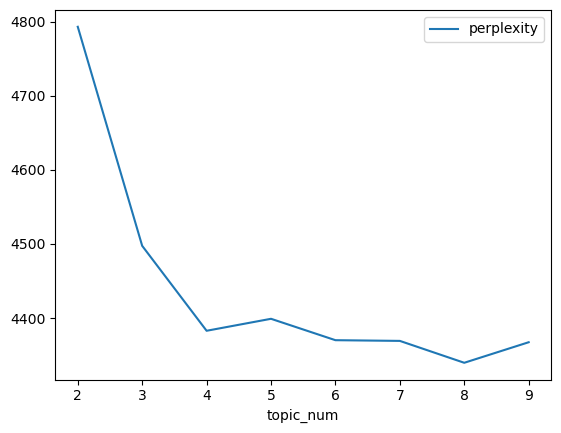

In [15]:
# 繪製perplexity圖表 , 發現 主題數 9為最佳
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

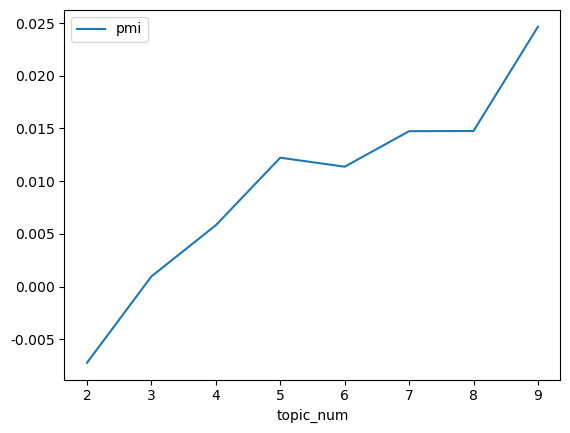

In [16]:
# 繪製pmi圖表 , 發現 主題數 8為最佳
result.plot.line(x='topic_num', y='pmi')

### 採用主題數 9 作為最佳主題模型進行建模

In [17]:

best_model = LdaModel(
    corpus = corpus,
    num_topics = 9,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

In [18]:
#從關鍵字觀察主題內容
best_model.print_topics(num_words=20)

[(0,
  '0.020*"電動車" + 0.016*"中國" + 0.014*"汽車" + 0.012*"台灣" + 0.010*"市場" + 0.008*"電池" + 0.007*"特斯拉" + 0.007*"品牌" + 0.006*"日本" + 0.006*"豐田" + 0.006*"車型" + 0.005*"美國" + 0.005*"公司" + 0.005*"銷售" + 0.004*"技術" + 0.004*"裕隆" + 0.004*"車廠" + 0.004*"原文" + 0.004*"消費者" + 0.004*"歐洲"'),
 (1,
  '0.023*"業務" + 0.018*"價格" + 0.013*"配備" + 0.013*"是否" + 0.013*"配件" + 0.011*"現金" + 0.010*"購車" + 0.010*"自費" + 0.009*"地點" + 0.009*"領牌" + 0.008*"型號" + 0.008*"隔熱" + 0.008*"貸款" + 0.008*"時間" + 0.008*"交車" + 0.007*"原廠" + 0.007*"空車" + 0.007*"稅金" + 0.006*"心得" + 0.006*"方式"'),
 (2,
  '0.022*"駕駛" + 0.013*"警方" + 0.013*"發生" + 0.012*"原文" + 0.010*"車禍" + 0.009*"國道" + 0.008*"車輛" + 0.008*"事故" + 0.007*"連結" + 0.007*"貨車" + 0.007*"肇事" + 0.006*"心得" + 0.006*"轎車" + 0.006*"男子" + 0.006*"記者" + 0.006*"原因" + 0.005*"說明" + 0.005*"車道" + 0.005*"內容" + 0.005*"報導"'),
 (3,
  '0.015*"行人" + 0.014*"違規" + 0.013*"交通" + 0.012*"台灣" + 0.012*"駕駛" + 0.010*"道路" + 0.009*"檢舉" + 0.009*"機車" + 0.009*"政府" + 0.009*"車道" + 0.008*"路口" + 0.007*"交通部" + 0.007*"汽車" + 0.006*"違停" +

### 以下是觀察出的9個主題以及命名

| 主題編號 | 主題名稱 | 關鍵字 |
|---------|---------|--------|
| 0 | 電動車市場與技術 | 電動車, 中國, 汽車, 台灣, 市場, 電池, 特斯拉, 品牌, 日本, 豐田, 車型, 美國, 公司, 銷售, 技術, 裕隆, 車廠, 原文, 消費者, 歐洲 |
| 1 | 購車交易與配備詢問 | 業務, 價格, 配備, 是否, 配件, 現金, 購車, 自費, 地點, 領牌, 型號, 隔熱, 貸款, 時間, 交車, 原廠, 空車, 稅金, 心得, 方式 |
| 2 | 車輛事故與警方報導 | 駕駛, 警方, 發生, 原文, 車禍, 國道, 車輛, 事故, 連結, 貨車, 肇事, 心得, 轎車, 男子, 記者, 原因, 說明, 車道, 內容, 報導 |
| 3 | 交通違規與安全 | 行人, 違規, 交通, 台灣, 駕駛, 道路, 檢舉, 機車, 政府, 車道, 路口, 交通部, 汽車, 違停, 執法, 安全, 左轉, 記點, 停車, 右轉 |
| 4 | 新聞與資訊分享 | 原文, 心得, 連結, 新聞, 駕駛, 特斯拉, 安全, 車主, 網址, 說明, 以上, 內容, 文章, 意見, 系統, 轉錄, 自動, 輔助, 附上, 台灣 |
| 5 | 停車管理與規範 | 停車, 檢舉, 違規, 停車場, 車位, 車牌, 車主, 規定, 民眾, 車輛, 違停, 管理, 處理, 路邊, 罰單, 停車位, 使用, 公司, 費用, 開單 |
| 6 | 電動車與油車比較 | 電車, 充電, 真的, 知道, 現在, 比較, 油車, 引述, 一下, 問題, 應該, 目前, 便宜, 看到, 覺得, 一台, 之銘言, 台灣, 車子, 特斯拉 |
| 7 | 駕駛與行車體驗 | 開車, 真的, 看到, 應該, 對方, 知道, 直接, 車道, 遇到, 問題, 一下, 覺得, 車子, 引述, 後面, 超車, 影片, 之銘言, 內線, 今天 |
| 8 | 車輛性能與駕馭感受 | 比較, 真的, 原廠, 覺得, 感覺, 問題, 空間, 應該, 引擎, 保養, 車子, 目前, 一下, 一台, 知道, 後座, 現在, 不錯, 看到, 有點 |


In [19]:
#透過pyLDAvis 進行視覺化呈現, 雖然主題 1, 4 有部分相連, 但改成8個主題時 又造成其他主題更多的相連, 故先維持9個主題
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.173215 -0.116299       1        1  22.741917
0      0.075287  0.187878       2        1  15.649292
7     -0.020391 -0.227608       3        1  14.128103
6      0.142899 -0.160935       4        1  10.720348
2     -0.260062 -0.021569       5        1  10.241114
3     -0.168128 -0.004012       6        1   8.361458
4     -0.057124  0.137629       7        1   7.486748
1      0.214862  0.147550       8        1   5.774831
5     -0.100557  0.057365       9        1   4.896189, topic_info=     Term         Freq        Total Category  logprob  loglift
1156  電動車  5216.000000  5216.000000  Default  30.0000  30.0000
99     中國  3750.000000  3750.000000  Default  29.0000  29.0000
201    駕駛  7510.000000  7510.000000  Default  28.0000  28.0000
273    原文  4885.000000  4885.000000  Default  27.0000  27.0000
313    檢舉  3091.000000  3091.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
1204   處理   424.214977  1778.403018   Topic9  -5.1617   1.5835
87     車輛   460.938725  4108.931493   Topic9  -5.0787   0.8291
1384   警察   312.088549  1291.885782   Topic9  -5.4686   1.5961
1401   公司   334.512911  2120.126907   Topic9  -5.3993   1.1702
102    使用   339.933341  2838.690922   Topic9  -5.3832   0.8944

[696 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
204       1  0.398826    一下
204       2  0.006389    一下
204       3  0.315031    一下
204       4  0.255318    一下
204       5  0.006143    一下
...     ...       ...   ...
2690      5  0.080703  高速公路
2690      6  0.106066  高速公路
2690      7  0.006149  高速公路
7664      6  0.992840    鳳山
9640      3  0.992661    黑紙

[1941 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 8, 7, 3, 4, 5, 2, 6])

### 觀察某段期間之主題分布情形

In [20]:
topics_doc = best_model.get_document_topics(corpus)

In [21]:
#看一下 theta 值
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.82241011, 0.        , ..., 0.09143235, 0.        ,
        0.08097932],
       [0.2384188 , 0.        , 0.        , ..., 0.        , 0.18423758,
        0.25970623],
       [0.        , 0.        , 0.15740603, ..., 0.        , 0.54824877,
        0.03875469],
       ...,
       [0.        , 0.        , 0.12796843, ..., 0.        , 0.16172738,
        0.        ],
       [0.06895707, 0.        , 0.22210746, ..., 0.14349148, 0.24253756,
        0.01975265],
       [0.42180988, 0.        , 0.        , ..., 0.21014531, 0.02167211,
        0.29417467]])

In [22]:
#將識別出的主題編號加入原先的資料集
car_df['topic_label'] = m_theta.argmax(axis=1) + 1

In [23]:
car_df['topic_label'].value_counts()

topic_label
9    4896
8    3067
7    1933
1    1818
3    1086
4    1002
5     790
2     650
6     499
Name: count, dtype: int64

In [29]:
#先將已經標示好主題編號的結果存檔, 方便日後叫用
car_df.to_csv('ptt_car_topic.csv', index=False)
car_df

,title,artDate,content,words,topic_label
0,菜單,2023-04-20,以下為建議資訊車輛廠牌年份型號福特車輛原廠編成等級最頂級是否含保險否是否含領牌稅金否成交價格...,"[以下, 建議, 資訊, 車輛廠, 年份, 型號, 福特, 車輛, 原廠, 編成, 等級, ...",2
1,討論台灣特斯拉開放的時程感覺快了,2023-04-20,大家晚安最近有觀察一些測試的一些影片感覺一些複雜路道車多的狀況有被改善許多的樣子覺得應該可以...,"[晚安, 最近, 觀察, 一些, 測試, 一些, 影片, 感覺, 一些, 複雜, 路道, 車...",9
2,分享違規的放棄人生號踢到鐵板,2023-04-20,引述之銘言影片連結起因是放棄人生號在雙黃線違規迴轉這位凱旋騎士跟著違規迴轉之後暴打放棄人生號...,"[引述, 之銘言, 影片, 連結, 起因, 放棄, 人生, 號在, 雙黃線, 違規, 迴轉,...",8
3,討論這是怎麼撞到的,2023-04-20,就是把馬路當賽道呀尤其是轉彎的時候出彎反而重踩油門所以當發現有人走在斑馬線上時根本來不及剎車...,"[馬路, 賽道, 尤其, 轉彎, 出彎, 踩油門, 發現, 有人, 斑馬線, 上時, 根本,...",8
4,討論是不是很多人以為汽車不能開最外線,2023-04-20,原文恕刪施主若從考慮安全的角度出發來討論這件事我舉雙手贊成但同時也請好好思考一件事每次在切外...,"[原文, 施主, 考慮, 安全, 角度, 發來, 討論, 這件, 我舉, 雙手贊成, 好好,...",4
...,...,...,...,...,...
15736,問題該跟誰,2024-04-20,後方如果這樣鈑金凹痕跟誰求償你如果是後方車主被困在車陣中無法離開你會如何處理發費文賺幣養家活...,"[後方, 凹痕, 求償, 後方, 車主, 被困, 車陣, 無法, 離開, 處理, 發費文, ...",8
15737,問題請教路邊停車費綁定信用卡問題,2024-04-20,請教各位專家們之前路邊停車費綁定信用卡扣款應該是錢包後來打給信用卡公司取消後停車單上面還是顯...,"[請教, 專家, 之前, 路邊, 停車費, 綁定, 信用卡, 扣款, 應該, 錢包, 打給,...",6
15738,新聞汽車小折都有綠委赴立院遭檢舉違停,2024-04-20,本文轉錄自看板作者看板標題新聞汽車小折都有綠委赴立院遭檢舉違停時間汽車小折都有綠委赴立院遭檢...,"[本文, 轉錄, 自看, 作者, 標題新聞, 汽車, 小折, 綠委赴, 立院, 檢舉, 違停...",4
15739,討論高速公路上用人工擺三角錐的風險,2024-04-20,引述超級噴火龍之銘言每每講到內線撞蠍子車就會有人出來講要擺三角錐啊看看這個就是人工擺三角一樣...,"[引述, 超級, 噴火龍, 之銘言, 講到, 內線, 蠍子, 車就會, 有人, 三角, 看看...",8


In [25]:
car_df['artDate'] = pd.to_datetime(car_df['artDate'])

In [26]:
#依日期彙總每天的各主題貼文數字
car_df.groupby(car_df['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2023-04-20  9              0.380952
            8              0.309524
            1              0.119048
            2              0.047619
            4              0.047619
                             ...   
2024-04-20  2              0.142857
            4              0.142857
            8              0.142857
            6              0.095238
            3              0.047619
Name: proportion, Length: 2918, dtype: float64

In [27]:
#unstack() 用來將多層索引轉換成表格
date_topic = car_df.groupby(car_df['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6,7,8,9
artDate,,,,,,,,,
2023-04-20,0.119048,0.047619,NaN,0.047619,0.047619,0.047619,NaN,0.309524,0.380952
2023-04-21,0.027778,0.027778,0.027778,0.083333,0.055556,0.083333,0.027778,0.388889,0.277778
2023-04-22,NaN,0.090909,0.090909,0.060606,0.030303,0.030303,0.030303,0.151515,0.515152
2023-04-23,0.033333,0.166667,0.033333,0.033333,0.033333,NaN,0.100000,0.233333,0.366667
2023-04-24,0.111111,0.083333,0.055556,0.027778,0.111111,0.027778,0.055556,0.111111,0.416667


-  可以發現 3/24 日那天 討論第七個主題(綠色) 電動車與油車的貼文明顯較其他日期為多
- 回朔 3/24 因為夏日電價的關係, 電車討論較多

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

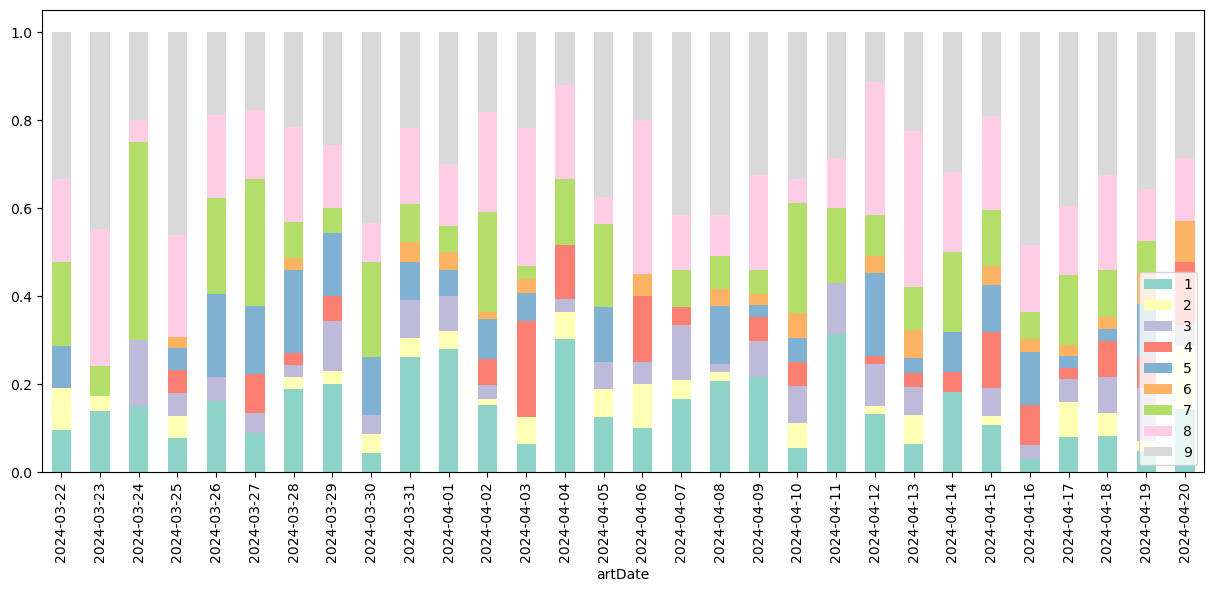

In [60]:
#繪製最近30日的每日主題分布圖

fig, ax = plt.subplots(figsize=(15, 6))
date_topic[-30:].plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

# 二. 分類任務
- 這裡我們嘗試使用bert-base-chinese模型對上述的汽車版資料集做embeddings，接著以之前標記好的主題模型類別訓練分類器。

- 預期效益: 透過機器學習模型可以識別新的帖子可能是關於前面9個主題模型的哪一個主題 , 例如如果判讀是 [購車交易與配備] 主題則可以轉發給業務

In [34]:
from sentence_transformers import SentenceTransformer, models, util

In [35]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')
bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with MEAN pooling.


0

In [101]:
#讀取前面已經標示好主題的汽車版資料集
car_topic = pd.read_csv("ptt_car_topic.csv")
car_topic

,title,artDate,content,words,topic_label
0,菜單,2023-04-20,以下為建議資訊車輛廠牌年份型號福特車輛原廠編成等級最頂級是否含保險否是否含領牌稅金否成交價格...,"['以下', '建議', '資訊', '車輛廠', '年份', '型號', '福特', '車...",2
1,討論台灣特斯拉開放的時程感覺快了,2023-04-20,大家晚安最近有觀察一些測試的一些影片感覺一些複雜路道車多的狀況有被改善許多的樣子覺得應該可以...,"['晚安', '最近', '觀察', '一些', '測試', '一些', '影片', '感覺...",9
2,分享違規的放棄人生號踢到鐵板,2023-04-20,引述之銘言影片連結起因是放棄人生號在雙黃線違規迴轉這位凱旋騎士跟著違規迴轉之後暴打放棄人生號...,"['引述', '之銘言', '影片', '連結', '起因', '放棄', '人生', '號...",8
3,討論這是怎麼撞到的,2023-04-20,就是把馬路當賽道呀尤其是轉彎的時候出彎反而重踩油門所以當發現有人走在斑馬線上時根本來不及剎車...,"['馬路', '賽道', '尤其', '轉彎', '出彎', '踩油門', '發現', '有...",8
4,討論是不是很多人以為汽車不能開最外線,2023-04-20,原文恕刪施主若從考慮安全的角度出發來討論這件事我舉雙手贊成但同時也請好好思考一件事每次在切外...,"['原文', '施主', '考慮', '安全', '角度', '發來', '討論', '這件...",4
...,...,...,...,...,...
15736,問題該跟誰,2024-04-20,後方如果這樣鈑金凹痕跟誰求償你如果是後方車主被困在車陣中無法離開你會如何處理發費文賺幣養家活...,"['後方', '凹痕', '求償', '後方', '車主', '被困', '車陣', '無法...",8
15737,問題請教路邊停車費綁定信用卡問題,2024-04-20,請教各位專家們之前路邊停車費綁定信用卡扣款應該是錢包後來打給信用卡公司取消後停車單上面還是顯...,"['請教', '專家', '之前', '路邊', '停車費', '綁定', '信用卡', '...",6
15738,新聞汽車小折都有綠委赴立院遭檢舉違停,2024-04-20,本文轉錄自看板作者看板標題新聞汽車小折都有綠委赴立院遭檢舉違停時間汽車小折都有綠委赴立院遭檢...,"['本文', '轉錄', '自看', '作者', '標題新聞', '汽車', '小折', '...",4
15739,討論高速公路上用人工擺三角錐的風險,2024-04-20,引述超級噴火龍之銘言每每講到內線撞蠍子車就會有人出來講要擺三角錐啊看看這個就是人工擺三角一樣...,"['引述', '超級', '噴火龍', '之銘言', '講到', '內線', '蠍子', '...",8


- embeddings需要較多運算時間 我們只先取前1000筆運算(100 筆約需一分多鐘)

In [102]:

car_topic = car_topic.dropna()
car_topic = car_topic.head(1000)
car_topic["embeddings"] = car_topic.content.apply(lambda x: bert_ch.encode(x))
car_topic

,title,artDate,content,words,topic_label,embeddings
0,菜單,2023-04-20,以下為建議資訊車輛廠牌年份型號福特車輛原廠編成等級最頂級是否含保險否是否含領牌稅金否成交價格...,"['以下', '建議', '資訊', '車輛廠', '年份', '型號', '福特', '車...",2,"[0.44455564, 0.070030235, -0.22971898, -0.0525..."
1,討論台灣特斯拉開放的時程感覺快了,2023-04-20,大家晚安最近有觀察一些測試的一些影片感覺一些複雜路道車多的狀況有被改善許多的樣子覺得應該可以...,"['晚安', '最近', '觀察', '一些', '測試', '一些', '影片', '感覺...",9,"[0.5223067, -0.40948626, -0.37725604, 0.199252..."
2,分享違規的放棄人生號踢到鐵板,2023-04-20,引述之銘言影片連結起因是放棄人生號在雙黃線違規迴轉這位凱旋騎士跟著違規迴轉之後暴打放棄人生號...,"['引述', '之銘言', '影片', '連結', '起因', '放棄', '人生', '號...",8,"[0.36232677, 0.06270436, -0.27290297, 0.187923..."
3,討論這是怎麼撞到的,2023-04-20,就是把馬路當賽道呀尤其是轉彎的時候出彎反而重踩油門所以當發現有人走在斑馬線上時根本來不及剎車...,"['馬路', '賽道', '尤其', '轉彎', '出彎', '踩油門', '發現', '有...",8,"[0.42876443, -0.10418015, -0.32743415, 0.46762..."
4,討論是不是很多人以為汽車不能開最外線,2023-04-20,原文恕刪施主若從考慮安全的角度出發來討論這件事我舉雙手贊成但同時也請好好思考一件事每次在切外...,"['原文', '施主', '考慮', '安全', '角度', '發來', '討論', '這件...",4,"[0.47509643, -0.0133083565, -0.33448333, 0.129..."
...,...,...,...,...,...,...
995,電車電動車位汽油車到底能不能停,2023-05-12,引述軍之銘言是這樣的今天到別人宿舍訪客整個停車場都沒有停車位看了一下剩下電動車位可以停到底電...,"['引述', '軍之銘言', '今天', '宿舍', '訪客', '整個', '停車場', ...",7,"[0.3762693, -0.20264305, -0.2036173, 0.2234499..."
996,問題油電真的有比較省嗎,2023-05-12,抱歉更正一下這個影片講的是版本因為有推文說兩者價差不到萬所以確認了一下官方定價萬純油萬油電跟...,"['抱歉', '更正', '一下', '影片', '講的', '版本', '文說', '價差...",9,"[0.6269388, 0.15654936, -0.28274184, 0.253118,..."
997,討論認真說不違停很難嗎,2023-05-12,引述秋風孤劍李鴻章之銘言檢舉他根本檢舉不完這是真的檢舉不完還未必全部受理成功有些人就是跟你嗆...,"['引述', '秋風', '孤劍', '李鴻章', '之銘言', '檢舉', '根本', '...",5,"[0.5405528, 0.11657959, -0.10043346, 0.2548116..."
998,討論理論全國人都保第三人是不是就不用車體,2023-05-13,是不是在全國都有第三人保險的前提下車體險就作用不大了一個性質是責任險一個性質是財物保險第一個...,"['全國', '第三', '前提', '車體', '作用', '性質', '責任險', '性...",6,"[0.617788, 0.031177824, -0.43436867, -0.032658..."


In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [104]:
#資料集處裡
data = car_topic.copy()
X = data["embeddings"].apply(pd.Series)
y = data["topic_label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

          0         1         2         3         4         5         6    \
275  0.333690 -0.264909 -0.489247  0.098088 -0.015404 -0.167364 -0.113301   
277  0.754551  0.049585 -0.476356  0.457753  0.157094 -0.165957 -0.054362   
464  0.539610 -0.262970 -0.264628  0.396292  0.159321 -0.287067  0.244133   
689  0.452365 -0.047393 -0.385415  0.398715 -0.253789 -0.251177  0.007345   
142  0.543272 -0.035960  0.095480  0.228244  0.098210 -0.210170  0.006119   

          7         8         9    ...       758       759       760  \
275  0.263761  0.007632 -0.362699  ...  0.203059 -0.125205  0.345472   
277  0.143177 -0.279171 -0.286173  ...  0.153680 -0.090199  0.053953   
464  0.229275 -0.026151  0.064114  ...  0.261923 -0.014454  0.093012   
689  0.116736 -0.276352 -0.287147  ...  0.071186 -0.289232  0.114130   
142 -0.128201 -0.049130 -0.315844  ... -0.013533 -0.103186  0.432667   

          761       762       763       764       765       766       767  
275 -0.044560 -0.344630  0.2

In [105]:
#選用羅吉斯回歸模型(經過實證其他三種模型指標效能只有些許差異)
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf

c:\Users\edwin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [106]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print(y_pred[:10])

[6 7 2 9 3 8 5 9 8 7]


In [107]:
from sklearn.metrics import classification_report

### weighted avg 中  f1-score 達 0.73 , 應還有調整空間, 例如主題數量的再調整,或是擴大訓練資料集到完整的1萬5000筆


In [108]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.78      0.79        32
           2       0.92      0.79      0.85        14
           3       0.89      0.86      0.88        29
           4       0.72      0.59      0.65        22
           5       0.70      0.44      0.54        16
           6       0.67      0.62      0.65        16
           7       0.46      0.48      0.47        27
           8       0.56      0.73      0.63        44
           9       0.82      0.83      0.83       100

    accuracy                           0.73       300
   macro avg       0.73      0.68      0.70       300
weighted avg       0.74      0.73      0.73       300

